e:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 1, 128)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,921 (195.00 KB)

 Trainable params: 49,921 (195.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6355 - loss: 0.5781 - val_accuracy: 0.9163 - val_loss: 0.3912
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9090 - loss: 0.3484 - val_accuracy: 0.9212 - val_loss: 0.2841
Epoch 3/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9159 - loss: 0.2634 - val_accuracy: 0.9283 - val_loss: 0.2292
Epoch 4/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9231 - loss: 0.2207 - val_accuracy: 0.9403 - val_loss: 0.1953
Epoch 5/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9335 - loss: 0.1879 - val_accuracy: 0.9403 - val_loss: 0.1710
Epoch 6/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9372 - loss: 0.1699 - val_accuracy: 0.9472 - val_loss: 0.1544
Epoch 7/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9410 - loss: 0.1554 - val_accuracy: 0.9465 - val_loss: 0.1424
Epoch 8/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9419 - loss: 0.1484 - val_accu

Model saved as rnn_model.h5

Model Performance Metrics:
Training Accuracy: 0.9631, Training Loss: 0.1009
Validation Accuracy: 0.9683, Validation Loss: 0.0865
Test Accuracy: 0.9641, Test Loss: 0.0954


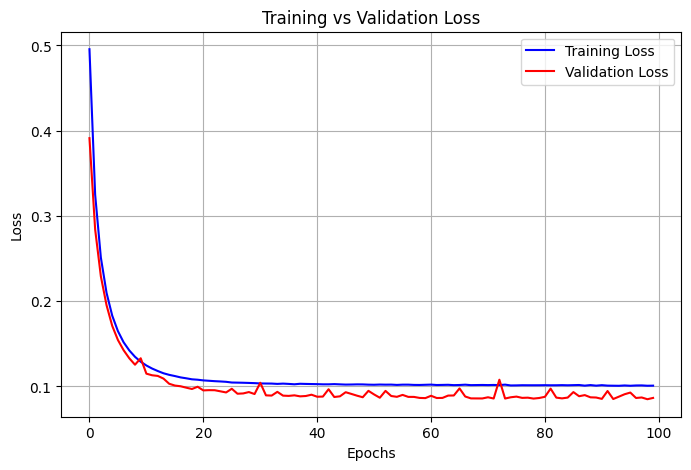

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Confusion Matrix:
[[1436   50]
 [ 112 2909]]

Classification Report:
              precision    recall  f1-score   support

      No CTS       0.93      0.97      0.95      1486
         CTS       0.98      0.96      0.97      3021

    accuracy                           0.96      4507
   macro avg       0.96      0.96      0.96      4507
weighted avg       0.96      0.96      0.96      4507



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = pd.read_csv(r"C:\Users\Admin\Downloads\EMG-data.csv")


relevant_classes = [1, 3, 4]
filtered_data = data[data['class'].isin(relevant_classes)].copy()


filtered_data['CTS_Label'] = (filtered_data['class'] != 1).astype(int)


columns_to_drop = ['time', 'label', 'class']
filtered_data = filtered_data.drop(columns=[col for col in columns_to_drop if col in filtered_data.columns])


numeric_cols = filtered_data.select_dtypes(include=[np.number]).columns
filtered_data[numeric_cols] = filtered_data[numeric_cols].fillna(
    filtered_data[numeric_cols].rolling(window=5, min_periods=1).mean()
)


window_size = 50
overlap = 25
channels = ['channel1', 'channel4', 'channel7']

if not all(col in filtered_data.columns for col in channels):
    raise ValueError(f"One or more selected channels {channels} do not exist in the dataset.")

data_array = filtered_data[channels].values
num_samples = data_array.shape[0]
num_windows = (num_samples - window_size) // (window_size - overlap) + 1


variance_features = np.zeros((num_windows, len(channels)))
window_labels = np.zeros(num_windows)

for w in range(num_windows):
    start_idx = w * (window_size - overlap)
    end_idx = start_idx + window_size
    window_data = data_array[start_idx:end_idx, :]
    variance_features[w, :] = np.var(window_data, axis=0)
    window_labels[w] = np.median(filtered_data['CTS_Label'].iloc[start_idx:end_idx])


threshold = np.percentile(variance_features, 75, axis=0)
cts_detected = (variance_features > threshold).any(axis=1)


window_labels = np.logical_or(window_labels, cts_detected).astype(int)


scaler = StandardScaler()
X_norm = scaler.fit_transform(variance_features)


X_train, X_temp, y_train, y_temp = train_test_split(X_norm, window_labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))


input_size = X_train.shape[2]  
hidden_size =128  
output_size = 1  

model = Sequential([
    SimpleRNN(hidden_size, input_shape=(X_train.shape[1], input_size), activation='relu', return_sequences=True),
    SimpleRNN(hidden_size, activation='tanh', return_sequences=False),
    Dense(output_size, activation='sigmoid')
])


model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    verbose=1
)


model.save("rnn_model.h5")
print("Model saved as rnn_model.h5")


train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)


print("\nModel Performance Metrics:")
print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}, Validation Loss: {valid_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
from sklearn.metrics import confusion_matrix, classification_report

# Predict class labels
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["No CTS", "CTS"])

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


model = tf.keras.models.load_model("rnn_model.h5")  
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
tflite_model = converter.convert()


with open("rnn_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as rnn_model.tflite")